<a href="https://colab.research.google.com/github/Chuqiao2333/MobileNetGray/blob/master/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobileNets V2 on GrayScale Image

In [0]:
!nvidia-smi

Sun Jan  5 01:41:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.utils.data
import torch.nn as nn
import h5py
import time
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os

In [0]:
num_epochs = 100
learning_rate = 0.0005
batch_size = 128
dropout_prob = 0.2
dropout_prob_1d = 0.5

In [0]:
transform_train = transforms.Compose([
    #transforms.Resize(224),
    transforms.Grayscale(1),
    #transforms.RandomCrop(64, padding=4),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(45),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_val = transforms.Compose([
    #transforms.Resize(224),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [0]:
#train_dir = '/content/drive/My Drive/hw/tiny-imagenet-200 3/train'
train_dataset = torchvision.datasets.CIFAR100(root='/content/drive/My Drive/hw',train=True,download=True, transform=transform_train)
print(train_dataset.class_to_idx)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

Files already downloaded and verified
{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, 'poppy': 62, 'porcupine': 63, 'possum': 64, 'rabbit': 65, 'raccoon': 66, 'ray': 67, 

In [0]:
val_dataset = torchvision.datasets.CIFAR100(root='/content/drive/My Drive/hw',train=False,download=True, transform=transform_val)
print(val_dataset.class_to_idx)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

Files already downloaded and verified
{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, 'poppy': 62, 'porcupine': 63, 'possum': 64, 'rabbit': 65, 'raccoon': 66, 'ray': 67, 

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
upsample = nn.Upsample(scale_factor=8, mode='bilinear') 

In [0]:
class Preprocess(nn.Module):
    def __init__(self):
        super(Preprocess, self).__init__()

        self.upsample = nn.Upsample(scale_factor=7, mode = 'bicubic')
        self.conv1    = nn.Conv2d(1,3,3,stride = 1, padding=1)
        self.conv2    = nn.Conv2d(3,10,3, stride=1, padding = 1)
        self.conv3    = nn.Conv2d(10,3,3, stride=1, padding = 1)

    def forward(self,x):

        
        x = self.upsample(x)
        input_X = self.conv1(x)
        x = self.conv2(input_X)
        x = self.conv3(x)
        x = x + input_X

        return x

In [0]:
def create_model():

    model = torch.hub.load('pytorch/vision:v0.4.2', 'mobilenet_v2', pretrained=True)
    model.classifier = nn.Linear(1280, 100)

    return model
class MobileNet_Gray(nn.Module):

    def __init__(self, Preprocess):

        super(MobileNet_Gray, self).__init__()

        self.one2three = Preprocess()
        self.model     = create_model()

    def forward(self,x):

        x = self.one2three(x)
        x = self.model(x)

        return x


In [0]:
model = MobileNet_Gray(Preprocess)

model.cuda()

temp_model = Preprocess()
temp_model.cuda()
from torchsummary import summary
summary(model, (1,32,32))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.4.2
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1          [-1, 1, 224, 224]               0
            Conv2d-2          [-1, 3, 224, 224]              30
            Conv2d-3         [-1, 10, 224, 224]             280
            Conv2d-4          [-1, 3, 224, 224]             273
        Preprocess-5          [-1, 3, 224, 224]               0
            Conv2d-6         [-1, 32, 112, 112]             864
       BatchNorm2d-7         [-1, 32, 112, 112]              64
             ReLU6-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 32, 112, 112]             288
      BatchNorm2d-10         [-1, 32, 112, 112]              64
            ReLU6-11         [-1, 32, 112, 112]               0
           Conv2d-12         [-1, 16, 112, 112]             512
      BatchNorm2d-13         [-1, 16, 112, 112]              32
 InvertedResidual-14         [-1, 16, 1

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)

In [0]:
start_time = time.time()
train_loss = []
val_loss = []
train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_accu = []
    model.train()
    train_running_loss = 0
    for batch_idx, (X_train_batch, Y_train_batch) in enumerate(train_loader):
        
        X_train_batch,Y_train_batch = Variable(X_train_batch).cuda(),Variable(Y_train_batch).cuda()
        
        
        output = model(X_train_batch)
        loss = criterion(output, Y_train_batch)
        optimizer.zero_grad()
        loss.backward()
        # if(epoch>6):
        #     for group in optimizer.param_groups:
        #         for p in group['params']:
        #             state = optimizer.state[p]
        #             if(state['step']>=1024):
        #                 state['step'] = 1000
        optimizer.step()
        prediction = output.data.max(1)[1]
        accuracy = ( float( prediction.eq(Y_train_batch.data).sum() ) /float(batch_size))*100.0
        train_accu.append(accuracy)
        train_running_loss += loss.item()

    scheduler.step()
    train_acc = np.mean(train_accu)
    train_loss.append(train_running_loss/len(train_loader))
    train_acc_list.append(train_acc)
# val the model
    if(epoch==50):
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate/10.0
    if(epoch==75):
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate/100.0

    with torch.no_grad():
        model.eval()
        val_accu = []
        val_running_loss = 0
        for batch_idx, (X_val_batch, Y_val_batch) in enumerate(val_loader):
            
            X_val_batch, Y_val_batch= Variable(X_val_batch).cuda(),Variable(Y_val_batch).cuda()
            
            
            output = model(X_val_batch)
            loss = criterion(output, Y_val_batch)
            val_running_loss += loss.item()
            prediction = output.data.max(1)[1] 
            accuracy = ( float( prediction.eq(Y_val_batch.data).sum() ) /float(batch_size))*100.0
            val_accu.append(accuracy)
        val_acc = np.mean(val_accu)
        val_loss.append(val_running_loss/len(val_loader))
        val_acc_list.append(val_acc)
    print('Epoch',epoch,'\nTrain accuracy',train_acc,'validation accuracy',val_acc,'Running time',time.time()-start_time)
    print('Training Loss = ',  train_loss[epoch], 'Val Loss =', val_loss[epoch])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 0 
Train accuracy 40.82680626598466 validation accuracy 47.923259493670884 Running time 167.8452959060669
Training Loss =  2.2462433183284674 Val Loss = 1.8460326496558854
Epoch 1 
Train accuracy 55.904331841432224 validation accuracy 55.07318037974684 Running time 335.7920792102814
Training Loss =  1.5534824242677225 Val Loss = 1.5425589431690265
Epoch 2 
Train accuracy 61.79667519181586 validation accuracy 58.57397151898734 Running time 503.5487470626831
Training Loss =  1.3357481736966106 Val Loss = 1.4304957133305223
Epoch 3 
Train accuracy 65.1974104859335 validation accuracy 60.57159810126582 Running time 671.2009723186493
Training Loss =  1.1939653505754593 Val Loss = 1.3694714488862436
Epoch 4 
Train accuracy 67.7769341432225 validation accuracy 59.889240506329116 Running time 839.0132076740265
Training Loss =  1.093120678154099 Val Loss = 1.3870880920675737
Epoch 5 
Train accuracy 70.13467071611254 validation accuracy 60.245253164556964 Running time 1006.9557859897614
Tr

In [0]:
  n   import matplotlib.pyplot as plt

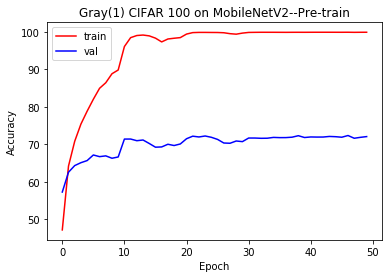

In [0]:
plt.plot(np.arange(50), train_acc_list[:50], color = 'r',label = 'train')
plt.plot(np.arange(50), val_acc_list[:50], color = 'b', label = 'val')
plt.title('Gray(1) CIFAR 100 on MobileNetV2--Pre-train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

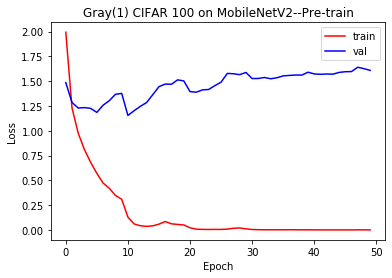

In [0]:
plt.plot(np.arange(50), train_loss[:50], color = 'r',label = 'train')
plt.plot(np.arange(50), val_loss[:50], color = 'b', label = 'val')
plt.title('Gray(1) CIFAR 100 on MobileNetV2--Pre-train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
import torch.nn as nn
import math
#MobileNet

def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                #nn.Dropout(0.2),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                #nn.Dropout(0.2),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                #nn.Dropout(0.2)
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=100, input_size=32, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 1],
            [6, 32, 3, 2],
            [6, 64, 4, 1],
            [6, 96, 3, 2],
            [6, 160, 3, 1],
            [6, 320, 1, 2],
        ]

        # building first layer
        assert input_size % 32 == 0
        # input_channel = make_divisible(input_channel * width_mult)  # first channel is always 32!
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(1, input_channel, 1)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def mobilenet_v2(pretrained=True):
    model = MobileNetV2(width_mult=1)

    if pretrained:
        try:
            from torch.hub import load_state_dict_from_url
        except ImportError:
            from torch.utils.model_zoo import load_url as load_state_dict_from_url
        state_dict = load_state_dict_from_url(
            'https://www.dropbox.com/s/47tyzpofuuyyv1b/mobilenetv2_1.0-f2a8633.pth.tar?dl=1', progress=True)
        model.load_state_dict(state_dict)
    return model


In [0]:
from torchsummary import summary

In [0]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=100):
        self.inplanes = 32
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1,
                              bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0],  stride=1)
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2)
        #self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(256 * block.expansion, num_classes)
        self.dropout = torch.nn.Dropout2d(p=dropout_prob)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)
        #print(x.shape)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #x = self.avgpool(x)
        # print(x.shape)
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)
        # print(x.shape)
       
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [0]:
model =  ResNet(BasicBlock,[2,4,4,2], num_classes=100)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [0]:
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
             ReLU-10           [-1, 32, 32, 32]               0
       BasicBlock-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,216
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,